In [135]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [136]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [137]:
sagemaker_session = sagemaker.Session()

In [138]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-gas-prices"  # prefix used for all data stored within the bucket
role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [139]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [140]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [141]:
data = pd.read_csv('DeepAR.csv', index_col=0, parse_dates=True)
num_timeseries = data.shape[1]
data_kw = data.resample("7D").sum() / 7
timeseries = []
for i in range(num_timeseries):
    timeseries.append(data_kw.iloc[:,i])
timeseries[0].index.freq='7D'

In [142]:
# we use 1 day frequency for the time series
freq = "7D"

# we predict for 
prediction_length = 153

# we use 100 days as context length, this is the number of state updates accomplished before making predictions
context_length = 100

In [143]:
start_dataset = pd.Timestamp("2015-07-30")
end_training = pd.Timestamp("2021-04-23")

In [144]:
training_data = [
    {
        "start": start_dataset.strftime('%Y-%m-%d'),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]

300
2021-04-22 00:00:00
Date
2015-07-30      0.000000
2015-08-06    335.321429
2015-08-13    171.527143
2015-08-20    147.735714
2015-08-27     62.555714
                 ...    
2024-02-29     72.615714
2024-03-07     66.354286
2024-03-14     42.375714
2024-03-21     29.847143
2024-03-28     16.537143
Freq: 7D, Name: Value, Length: 453, dtype: float64


In [145]:
# num_test_windows = 4

test_data = [
    {
        "start": start_dataset.strftime('%Y-%m-%d'),
        "target": ts[start_dataset : end_training + timedelta(days=7*prediction_length)].tolist(),
    }
    # for k in range(1, num_test_windows + 1)
    for ts in timeseries
]

In [149]:
# save test data
import numpy as np
np.save('DeepArTest', test_data[0]['target'][len(training_data[0]['target']):])

In [77]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [78]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 2.56 ms, sys: 0 ns, total: 2.56 ms
Wall time: 2.07 ms


In [79]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=True):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [80]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Overwriting existing file
Uploading file to s3://sagemaker-us-east-2-533267229950/deepar-gas-prices/data/train/train.json
Overwriting existing file
Uploading file to s3://sagemaker-us-east-2-533267229950/deepar-gas-prices/data/test/test.json
CPU times: user 31.7 ms, sys: 2.69 ms, total: 34.4 ms
Wall time: 145 ms


In [81]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2015-07-30", "target": [0.0, 335.32142857142856, 171.52714285714288, 147.7357142857143, 6...


In [82]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-gas-prices",
    output_path=s3_output_path,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [83]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "200",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [84]:
estimator.set_hyperparameters(**hyperparameters)

In [85]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: deepar-gas-prices-2024-04-10-21-11-53-938


2024-04-10 21:11:54 Starting - Starting the training job...
2024-04-10 21:12:09 Starting - Preparing the instances for training......
2024-04-10 21:13:10 Downloading - Downloading input data...
2024-04-10 21:13:35 Downloading - Downloading the training image...............
2024-04-10 21:16:21 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[04/10/2024 21:16:39 INFO 139627334805312] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patienc

[04/10/2024 21:16:51 INFO 139627334805312] Epoch[1] Batch[5] avg_epoch_loss=3.551490
[04/10/2024 21:16:51 INFO 139627334805312] #quality_metric: host=algo-1, epoch=1, batch=5 train loss <loss>=3.5514903465906777
[04/10/2024 21:16:51 INFO 139627334805312] Epoch[1] Batch [5]#011Speed: 117.82 samples/sec#011loss=3.551490
[04/10/2024 21:16:53 INFO 139627334805312] processed a total of 620 examples
#metrics {"StartTime": 1712783807.8771653, "EndTime": 1712783813.4419286, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5564.700365066528, "count": 1, "min": 5564.700365066528, "max": 5564.700365066528}}}
[04/10/2024 21:16:53 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=111.41445763744332 records/second
[04/10/2024 21:16:53 INFO 139627334805312] #progress_metric: host=algo-1, completed 1.0 % of epochs
[04/10/2024 21:16:53 INFO 139627334805312] #quality_metric: host=algo-1, epoch=1, train loss <lo

[04/10/2024 21:17:26 INFO 139627334805312] Epoch[7] Batch[5] avg_epoch_loss=2.845819
[04/10/2024 21:17:26 INFO 139627334805312] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=2.845818877220154
[04/10/2024 21:17:26 INFO 139627334805312] Epoch[7] Batch [5]#011Speed: 120.19 samples/sec#011loss=2.845819
[04/10/2024 21:17:28 INFO 139627334805312] processed a total of 640 examples
#metrics {"StartTime": 1712783843.0844316, "EndTime": 1712783848.5861664, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5501.422882080078, "count": 1, "min": 5501.422882080078, "max": 5501.422882080078}}}
[04/10/2024 21:17:28 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=116.33134209395453 records/second
[04/10/2024 21:17:28 INFO 139627334805312] #progress_metric: host=algo-1, completed 4.0 % of epochs
[04/10/2024 21:17:28 INFO 139627334805312] #quality_metric: host=algo-1, epoch=7, train loss <los

[04/10/2024 21:17:55 INFO 139627334805312] Epoch[12] Batch[5] avg_epoch_loss=2.640738
[04/10/2024 21:17:55 INFO 139627334805312] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=2.640738288561503
[04/10/2024 21:17:55 INFO 139627334805312] Epoch[12] Batch [5]#011Speed: 120.12 samples/sec#011loss=2.640738
[04/10/2024 21:17:58 INFO 139627334805312] Epoch[12] Batch[10] avg_epoch_loss=2.607868
[04/10/2024 21:17:58 INFO 139627334805312] #quality_metric: host=algo-1, epoch=12, batch=10 train loss <loss>=2.568423128128052
[04/10/2024 21:17:58 INFO 139627334805312] Epoch[12] Batch [10]#011Speed: 119.58 samples/sec#011loss=2.568423
[04/10/2024 21:17:58 INFO 139627334805312] processed a total of 652 examples
#metrics {"StartTime": 1712783872.0893514, "EndTime": 1712783878.1331072, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6043.699264526367, "count": 1, "min": 6043.699264526367, "max": 6043.699264526367

[04/10/2024 21:18:24 INFO 139627334805312] Epoch[17] Batch[5] avg_epoch_loss=2.545647
[04/10/2024 21:18:24 INFO 139627334805312] #quality_metric: host=algo-1, epoch=17, batch=5 train loss <loss>=2.545646627744039
[04/10/2024 21:18:24 INFO 139627334805312] Epoch[17] Batch [5]#011Speed: 120.04 samples/sec#011loss=2.545647
[04/10/2024 21:18:26 INFO 139627334805312] processed a total of 625 examples
#metrics {"StartTime": 1712783901.1098983, "EndTime": 1712783906.6125183, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5502.562522888184, "count": 1, "min": 5502.562522888184, "max": 5502.562522888184}}}
[04/10/2024 21:18:26 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=113.58149475715058 records/second
[04/10/2024 21:18:26 INFO 139627334805312] #progress_metric: host=algo-1, completed 9.0 % of epochs
[04/10/2024 21:18:26 INFO 139627334805312] #quality_metric: host=algo-1, epoch=17, train loss 

[04/10/2024 21:18:54 INFO 139627334805312] Epoch[22] Batch[5] avg_epoch_loss=2.475248
[04/10/2024 21:18:54 INFO 139627334805312] #quality_metric: host=algo-1, epoch=22, batch=5 train loss <loss>=2.4752482573191323
[04/10/2024 21:18:54 INFO 139627334805312] Epoch[22] Batch [5]#011Speed: 116.30 samples/sec#011loss=2.475248
[04/10/2024 21:18:56 INFO 139627334805312] processed a total of 625 examples
#metrics {"StartTime": 1712783931.0225317, "EndTime": 1712783936.6748931, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5652.296304702759, "count": 1, "min": 5652.296304702759, "max": 5652.296304702759}}}
[04/10/2024 21:18:56 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=110.5724205613985 records/second
[04/10/2024 21:18:56 INFO 139627334805312] #progress_metric: host=algo-1, completed 11.5 % of epochs
[04/10/2024 21:18:56 INFO 139627334805312] #quality_metric: host=algo-1, epoch=22, train loss

[04/10/2024 21:19:23 INFO 139627334805312] Epoch[27] Batch[5] avg_epoch_loss=2.386025
[04/10/2024 21:19:23 INFO 139627334805312] #quality_metric: host=algo-1, epoch=27, batch=5 train loss <loss>=2.3860251108805337
[04/10/2024 21:19:23 INFO 139627334805312] Epoch[27] Batch [5]#011Speed: 119.89 samples/sec#011loss=2.386025
[04/10/2024 21:19:26 INFO 139627334805312] Epoch[27] Batch[10] avg_epoch_loss=2.408148
[04/10/2024 21:19:26 INFO 139627334805312] #quality_metric: host=algo-1, epoch=27, batch=10 train loss <loss>=2.434694766998291
[04/10/2024 21:19:26 INFO 139627334805312] Epoch[27] Batch [10]#011Speed: 120.05 samples/sec#011loss=2.434695
[04/10/2024 21:19:26 INFO 139627334805312] processed a total of 657 examples
#metrics {"StartTime": 1712783960.2838688, "EndTime": 1712783966.3190606, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6035.134077072144, "count": 1, "min": 6035.134077072144, "max": 6035.13407707214

[04/10/2024 21:19:53 INFO 139627334805312] Epoch[32] Batch[5] avg_epoch_loss=2.327003
[04/10/2024 21:19:53 INFO 139627334805312] #quality_metric: host=algo-1, epoch=32, batch=5 train loss <loss>=2.3270031611124673
[04/10/2024 21:19:53 INFO 139627334805312] Epoch[32] Batch [5]#011Speed: 120.88 samples/sec#011loss=2.327003
[04/10/2024 21:19:55 INFO 139627334805312] processed a total of 638 examples
#metrics {"StartTime": 1712783990.53141, "EndTime": 1712783995.9989965, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5467.291355133057, "count": 1, "min": 5467.291355133057, "max": 5467.291355133057}}}
[04/10/2024 21:19:55 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=116.69177368345497 records/second
[04/10/2024 21:19:55 INFO 139627334805312] #progress_metric: host=algo-1, completed 16.5 % of epochs
[04/10/2024 21:19:55 INFO 139627334805312] #quality_metric: host=algo-1, epoch=32, train loss 

[04/10/2024 21:20:28 INFO 139627334805312] Epoch[38] Batch[5] avg_epoch_loss=2.290017
[04/10/2024 21:20:28 INFO 139627334805312] #quality_metric: host=algo-1, epoch=38, batch=5 train loss <loss>=2.290016849835714
[04/10/2024 21:20:28 INFO 139627334805312] Epoch[38] Batch [5]#011Speed: 120.55 samples/sec#011loss=2.290017
[04/10/2024 21:20:31 INFO 139627334805312] processed a total of 587 examples
#metrics {"StartTime": 1712784025.551877, "EndTime": 1712784031.0388722, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5486.7002964019775, "count": 1, "min": 5486.7002964019775, "max": 5486.7002964019775}}}
[04/10/2024 21:20:31 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=106.98410501200784 records/second
[04/10/2024 21:20:31 INFO 139627334805312] #progress_metric: host=algo-1, completed 19.5 % of epochs
[04/10/2024 21:20:31 INFO 139627334805312] #quality_metric: host=algo-1, epoch=38, train lo

[04/10/2024 21:21:03 INFO 139627334805312] Epoch[44] Batch[5] avg_epoch_loss=2.253369
[04/10/2024 21:21:03 INFO 139627334805312] #quality_metric: host=algo-1, epoch=44, batch=5 train loss <loss>=2.2533686558405557
[04/10/2024 21:21:03 INFO 139627334805312] Epoch[44] Batch [5]#011Speed: 108.20 samples/sec#011loss=2.253369
[04/10/2024 21:21:05 INFO 139627334805312] processed a total of 620 examples
#metrics {"StartTime": 1712784060.0090396, "EndTime": 1712784065.8251717, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5815.828084945679, "count": 1, "min": 5815.828084945679, "max": 5815.828084945679}}}
[04/10/2024 21:21:05 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=106.60270781948641 records/second
[04/10/2024 21:21:05 INFO 139627334805312] #progress_metric: host=algo-1, completed 22.5 % of epochs
[04/10/2024 21:21:05 INFO 139627334805312] #quality_metric: host=algo-1, epoch=44, train los

[04/10/2024 21:21:38 INFO 139627334805312] Epoch[50] Batch[5] avg_epoch_loss=2.196604
[04/10/2024 21:21:38 INFO 139627334805312] #quality_metric: host=algo-1, epoch=50, batch=5 train loss <loss>=2.1966044902801514
[04/10/2024 21:21:38 INFO 139627334805312] Epoch[50] Batch [5]#011Speed: 115.52 samples/sec#011loss=2.196604
[04/10/2024 21:21:40 INFO 139627334805312] processed a total of 617 examples
#metrics {"StartTime": 1712784095.06395, "EndTime": 1712784100.7934535, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5729.0637493133545, "count": 1, "min": 5729.0637493133545, "max": 5729.0637493133545}}}
[04/10/2024 21:21:40 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=107.6944498451262 records/second
[04/10/2024 21:21:40 INFO 139627334805312] #progress_metric: host=algo-1, completed 25.5 % of epochs
[04/10/2024 21:21:40 INFO 139627334805312] #quality_metric: host=algo-1, epoch=50, train los

[04/10/2024 21:22:18 INFO 139627334805312] Epoch[57] Batch[5] avg_epoch_loss=2.195875
[04/10/2024 21:22:18 INFO 139627334805312] #quality_metric: host=algo-1, epoch=57, batch=5 train loss <loss>=2.1958752075831094
[04/10/2024 21:22:18 INFO 139627334805312] Epoch[57] Batch [5]#011Speed: 120.90 samples/sec#011loss=2.195875
[04/10/2024 21:22:21 INFO 139627334805312] processed a total of 630 examples
#metrics {"StartTime": 1712784135.5626395, "EndTime": 1712784141.0457041, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5482.341051101685, "count": 1, "min": 5482.341051101685, "max": 5482.341051101685}}}
[04/10/2024 21:22:21 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=114.91216850371389 records/second
[04/10/2024 21:22:21 INFO 139627334805312] #progress_metric: host=algo-1, completed 29.0 % of epochs
[04/10/2024 21:22:21 INFO 139627334805312] #quality_metric: host=algo-1, epoch=57, train los

[04/10/2024 21:22:59 INFO 139627334805312] Epoch[64] Batch[5] avg_epoch_loss=2.166012
[04/10/2024 21:22:59 INFO 139627334805312] #quality_metric: host=algo-1, epoch=64, batch=5 train loss <loss>=2.1660118103027344
[04/10/2024 21:22:59 INFO 139627334805312] Epoch[64] Batch [5]#011Speed: 119.74 samples/sec#011loss=2.166012
[04/10/2024 21:23:01 INFO 139627334805312] Epoch[64] Batch[10] avg_epoch_loss=2.163611
[04/10/2024 21:23:01 INFO 139627334805312] #quality_metric: host=algo-1, epoch=64, batch=10 train loss <loss>=2.160730791091919
[04/10/2024 21:23:01 INFO 139627334805312] Epoch[64] Batch [10]#011Speed: 118.85 samples/sec#011loss=2.160731
[04/10/2024 21:23:01 INFO 139627334805312] processed a total of 642 examples
#metrics {"StartTime": 1712784175.8191948, "EndTime": 1712784181.891324, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6071.788549423218, "count": 1, "min": 6071.788549423218, "max": 6071.788549423218

[04/10/2024 21:23:30 INFO 139627334805312] Epoch[69] Batch[5] avg_epoch_loss=2.132741
[04/10/2024 21:23:30 INFO 139627334805312] #quality_metric: host=algo-1, epoch=69, batch=5 train loss <loss>=2.1327414512634277
[04/10/2024 21:23:30 INFO 139627334805312] Epoch[69] Batch [5]#011Speed: 120.58 samples/sec#011loss=2.132741
[04/10/2024 21:23:32 INFO 139627334805312] processed a total of 617 examples
#metrics {"StartTime": 1712784206.7525072, "EndTime": 1712784212.2495306, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5496.672630310059, "count": 1, "min": 5496.672630310059, "max": 5496.672630310059}}}
[04/10/2024 21:23:32 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=112.24756488352283 records/second
[04/10/2024 21:23:32 INFO 139627334805312] #progress_metric: host=algo-1, completed 35.0 % of epochs
[04/10/2024 21:23:32 INFO 139627334805312] #quality_metric: host=algo-1, epoch=69, train los

[04/10/2024 21:24:10 INFO 139627334805312] Epoch[76] Batch[5] avg_epoch_loss=2.078033
[04/10/2024 21:24:10 INFO 139627334805312] #quality_metric: host=algo-1, epoch=76, batch=5 train loss <loss>=2.0780327320098877
[04/10/2024 21:24:10 INFO 139627334805312] Epoch[76] Batch [5]#011Speed: 120.14 samples/sec#011loss=2.078033
[04/10/2024 21:24:13 INFO 139627334805312] Epoch[76] Batch[10] avg_epoch_loss=2.100316
[04/10/2024 21:24:13 INFO 139627334805312] #quality_metric: host=algo-1, epoch=76, batch=10 train loss <loss>=2.127055025100708
[04/10/2024 21:24:13 INFO 139627334805312] Epoch[76] Batch [10]#011Speed: 119.25 samples/sec#011loss=2.127055
[04/10/2024 21:24:13 INFO 139627334805312] processed a total of 672 examples
#metrics {"StartTime": 1712784247.207982, "EndTime": 1712784253.2667184, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6058.316707611084, "count": 1, "min": 6058.316707611084, "max": 6058.316707611084

[04/10/2024 21:24:40 INFO 139627334805312] Epoch[81] Batch[5] avg_epoch_loss=2.076058
[04/10/2024 21:24:40 INFO 139627334805312] #quality_metric: host=algo-1, epoch=81, batch=5 train loss <loss>=2.0760576725006104
[04/10/2024 21:24:40 INFO 139627334805312] Epoch[81] Batch [5]#011Speed: 119.11 samples/sec#011loss=2.076058
[04/10/2024 21:24:43 INFO 139627334805312] Epoch[81] Batch[10] avg_epoch_loss=2.031154
[04/10/2024 21:24:43 INFO 139627334805312] #quality_metric: host=algo-1, epoch=81, batch=10 train loss <loss>=1.977269458770752
[04/10/2024 21:24:43 INFO 139627334805312] Epoch[81] Batch [10]#011Speed: 119.64 samples/sec#011loss=1.977269
[04/10/2024 21:24:43 INFO 139627334805312] processed a total of 642 examples
#metrics {"StartTime": 1712784277.033323, "EndTime": 1712784283.1107492, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6077.128171920776, "count": 1, "min": 6077.128171920776, "max": 6077.128171920776

[04/10/2024 21:25:09 INFO 139627334805312] Epoch[86] Batch[5] avg_epoch_loss=2.047454
[04/10/2024 21:25:09 INFO 139627334805312] #quality_metric: host=algo-1, epoch=86, batch=5 train loss <loss>=2.0474543372790017
[04/10/2024 21:25:09 INFO 139627334805312] Epoch[86] Batch [5]#011Speed: 120.69 samples/sec#011loss=2.047454
[04/10/2024 21:25:12 INFO 139627334805312] Epoch[86] Batch[10] avg_epoch_loss=2.028859
[04/10/2024 21:25:12 INFO 139627334805312] #quality_metric: host=algo-1, epoch=86, batch=10 train loss <loss>=2.006544017791748
[04/10/2024 21:25:12 INFO 139627334805312] Epoch[86] Batch [10]#011Speed: 120.02 samples/sec#011loss=2.006544
[04/10/2024 21:25:12 INFO 139627334805312] processed a total of 645 examples
#metrics {"StartTime": 1712784306.5800793, "EndTime": 1712784312.6284404, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6048.01607131958, "count": 1, "min": 6048.01607131958, "max": 6048.01607131958}}

[04/10/2024 21:25:39 INFO 139627334805312] Epoch[91] Batch[5] avg_epoch_loss=2.032761
[04/10/2024 21:25:39 INFO 139627334805312] #quality_metric: host=algo-1, epoch=91, batch=5 train loss <loss>=2.0327606995900473
[04/10/2024 21:25:39 INFO 139627334805312] Epoch[91] Batch [5]#011Speed: 118.48 samples/sec#011loss=2.032761
[04/10/2024 21:25:41 INFO 139627334805312] processed a total of 616 examples
#metrics {"StartTime": 1712784336.4143429, "EndTime": 1712784341.9846444, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5570.213079452515, "count": 1, "min": 5570.213079452515, "max": 5570.213079452515}}}
[04/10/2024 21:25:41 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=110.58579140051641 records/second
[04/10/2024 21:25:41 INFO 139627334805312] #progress_metric: host=algo-1, completed 46.0 % of epochs
[04/10/2024 21:25:41 INFO 139627334805312] #quality_metric: host=algo-1, epoch=91, train los

[04/10/2024 21:26:10 INFO 139627334805312] Epoch[96] Batch[5] avg_epoch_loss=2.131168
[04/10/2024 21:26:10 INFO 139627334805312] #quality_metric: host=algo-1, epoch=96, batch=5 train loss <loss>=2.1311678886413574
[04/10/2024 21:26:10 INFO 139627334805312] Epoch[96] Batch [5]#011Speed: 113.96 samples/sec#011loss=2.131168
[04/10/2024 21:26:12 INFO 139627334805312] processed a total of 623 examples
#metrics {"StartTime": 1712784366.7056997, "EndTime": 1712784372.5180721, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5812.025785446167, "count": 1, "min": 5812.025785446167, "max": 5812.025785446167}}}
[04/10/2024 21:26:12 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=107.18953588171955 records/second
[04/10/2024 21:26:12 INFO 139627334805312] #progress_metric: host=algo-1, completed 48.5 % of epochs
[04/10/2024 21:26:12 INFO 139627334805312] #quality_metric: host=algo-1, epoch=96, train los

[04/10/2024 21:26:50 INFO 139627334805312] Epoch[103] Batch[5] avg_epoch_loss=2.016136
[04/10/2024 21:26:50 INFO 139627334805312] #quality_metric: host=algo-1, epoch=103, batch=5 train loss <loss>=2.0161363085110984
[04/10/2024 21:26:50 INFO 139627334805312] Epoch[103] Batch [5]#011Speed: 120.61 samples/sec#011loss=2.016136
[04/10/2024 21:26:53 INFO 139627334805312] processed a total of 623 examples
#metrics {"StartTime": 1712784407.6365259, "EndTime": 1712784413.1150484, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5478.144884109497, "count": 1, "min": 5478.144884109497, "max": 5478.144884109497}}}
[04/10/2024 21:26:53 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=113.72252154733921 records/second
[04/10/2024 21:26:53 INFO 139627334805312] #progress_metric: host=algo-1, completed 52.0 % of epochs
[04/10/2024 21:26:53 INFO 139627334805312] #quality_metric: host=algo-1, epoch=103, train

[04/10/2024 21:27:30 INFO 139627334805312] Epoch[110] Batch[5] avg_epoch_loss=2.004340
[04/10/2024 21:27:30 INFO 139627334805312] #quality_metric: host=algo-1, epoch=110, batch=5 train loss <loss>=2.0043402115503945
[04/10/2024 21:27:30 INFO 139627334805312] Epoch[110] Batch [5]#011Speed: 118.90 samples/sec#011loss=2.004340
[04/10/2024 21:27:32 INFO 139627334805312] processed a total of 608 examples
#metrics {"StartTime": 1712784447.0688293, "EndTime": 1712784452.6333916, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5564.184188842773, "count": 1, "min": 5564.184188842773, "max": 5564.184188842773}}}
[04/10/2024 21:27:32 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=109.2682497429656 records/second
[04/10/2024 21:27:32 INFO 139627334805312] #progress_metric: host=algo-1, completed 55.5 % of epochs
[04/10/2024 21:27:32 INFO 139627334805312] #quality_metric: host=algo-1, epoch=110, train 

[04/10/2024 21:28:00 INFO 139627334805312] Epoch[115] Batch[5] avg_epoch_loss=1.981423
[04/10/2024 21:28:00 INFO 139627334805312] #quality_metric: host=algo-1, epoch=115, batch=5 train loss <loss>=1.9814234574635823
[04/10/2024 21:28:00 INFO 139627334805312] Epoch[115] Batch [5]#011Speed: 119.59 samples/sec#011loss=1.981423
[04/10/2024 21:28:02 INFO 139627334805312] Epoch[115] Batch[10] avg_epoch_loss=1.991652
[04/10/2024 21:28:02 INFO 139627334805312] #quality_metric: host=algo-1, epoch=115, batch=10 train loss <loss>=2.003927206993103
[04/10/2024 21:28:02 INFO 139627334805312] Epoch[115] Batch [10]#011Speed: 110.92 samples/sec#011loss=2.003927
[04/10/2024 21:28:02 INFO 139627334805312] processed a total of 657 examples
#metrics {"StartTime": 1712784476.624813, "EndTime": 1712784482.90633, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6281.1174392700195, "count": 1, "min": 6281.1174392700195, "max": 6281.117439

[04/10/2024 21:28:30 INFO 139627334805312] Epoch[120] Batch[5] avg_epoch_loss=1.995259
[04/10/2024 21:28:30 INFO 139627334805312] #quality_metric: host=algo-1, epoch=120, batch=5 train loss <loss>=1.9952585299809773
[04/10/2024 21:28:30 INFO 139627334805312] Epoch[120] Batch [5]#011Speed: 120.75 samples/sec#011loss=1.995259
[04/10/2024 21:28:32 INFO 139627334805312] processed a total of 638 examples
#metrics {"StartTime": 1712784507.2350144, "EndTime": 1712784512.73735, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5502.046823501587, "count": 1, "min": 5502.046823501587, "max": 5502.046823501587}}}
[04/10/2024 21:28:32 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=115.95465595282856 records/second
[04/10/2024 21:28:32 INFO 139627334805312] #progress_metric: host=algo-1, completed 60.5 % of epochs
[04/10/2024 21:28:32 INFO 139627334805312] #quality_metric: host=algo-1, epoch=120, train l

[04/10/2024 21:29:13 INFO 139627334805312] Epoch[127] Batch[5] avg_epoch_loss=1.974418
[04/10/2024 21:29:13 INFO 139627334805312] #quality_metric: host=algo-1, epoch=127, batch=5 train loss <loss>=1.9744176467259724
[04/10/2024 21:29:13 INFO 139627334805312] Epoch[127] Batch [5]#011Speed: 111.96 samples/sec#011loss=1.974418
[04/10/2024 21:29:16 INFO 139627334805312] Epoch[127] Batch[10] avg_epoch_loss=1.989213
[04/10/2024 21:29:16 INFO 139627334805312] #quality_metric: host=algo-1, epoch=127, batch=10 train loss <loss>=2.0069676876068114
[04/10/2024 21:29:16 INFO 139627334805312] Epoch[127] Batch [10]#011Speed: 111.63 samples/sec#011loss=2.006968
[04/10/2024 21:29:16 INFO 139627334805312] processed a total of 649 examples
#metrics {"StartTime": 1712784549.8949444, "EndTime": 1712784556.3718376, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6476.590871810913, "count": 1, "min": 6476.590871810913, "max": 6476.5908

[04/10/2024 21:29:55 INFO 139627334805312] Epoch[134] Batch[5] avg_epoch_loss=1.907251
[04/10/2024 21:29:55 INFO 139627334805312] #quality_metric: host=algo-1, epoch=134, batch=5 train loss <loss>=1.9072506825129192
[04/10/2024 21:29:55 INFO 139627334805312] Epoch[134] Batch [5]#011Speed: 119.79 samples/sec#011loss=1.907251
[04/10/2024 21:29:57 INFO 139627334805312] processed a total of 631 examples
#metrics {"StartTime": 1712784591.8539252, "EndTime": 1712784597.3931775, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5539.191961288452, "count": 1, "min": 5539.191961288452, "max": 5539.191961288452}}}
[04/10/2024 21:29:57 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=113.9123353841038 records/second
[04/10/2024 21:29:57 INFO 139627334805312] #progress_metric: host=algo-1, completed 67.5 % of epochs
[04/10/2024 21:29:57 INFO 139627334805312] #quality_metric: host=algo-1, epoch=134, train 

[04/10/2024 21:30:24 INFO 139627334805312] Epoch[139] Batch[5] avg_epoch_loss=1.927517
[04/10/2024 21:30:24 INFO 139627334805312] #quality_metric: host=algo-1, epoch=139, batch=5 train loss <loss>=1.9275170763333638
[04/10/2024 21:30:24 INFO 139627334805312] Epoch[139] Batch [5]#011Speed: 120.12 samples/sec#011loss=1.927517
[04/10/2024 21:30:27 INFO 139627334805312] Epoch[139] Batch[10] avg_epoch_loss=1.912477
[04/10/2024 21:30:27 INFO 139627334805312] #quality_metric: host=algo-1, epoch=139, batch=10 train loss <loss>=1.8944287538528441
[04/10/2024 21:30:27 INFO 139627334805312] Epoch[139] Batch [10]#011Speed: 118.74 samples/sec#011loss=1.894429
[04/10/2024 21:30:27 INFO 139627334805312] processed a total of 668 examples
#metrics {"StartTime": 1712784621.0222313, "EndTime": 1712784627.086172, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6063.516855239868, "count": 1, "min": 6063.516855239868, "max": 6063.51685

[04/10/2024 21:30:54 INFO 139627334805312] Epoch[144] Batch[5] avg_epoch_loss=1.931889
[04/10/2024 21:30:54 INFO 139627334805312] #quality_metric: host=algo-1, epoch=144, batch=5 train loss <loss>=1.931889255841573
[04/10/2024 21:30:54 INFO 139627334805312] Epoch[144] Batch [5]#011Speed: 119.01 samples/sec#011loss=1.931889
[04/10/2024 21:30:57 INFO 139627334805312] Epoch[144] Batch[10] avg_epoch_loss=1.923401
[04/10/2024 21:30:57 INFO 139627334805312] #quality_metric: host=algo-1, epoch=144, batch=10 train loss <loss>=1.913214421272278
[04/10/2024 21:30:57 INFO 139627334805312] Epoch[144] Batch [10]#011Speed: 119.38 samples/sec#011loss=1.913214
[04/10/2024 21:30:57 INFO 139627334805312] processed a total of 642 examples
#metrics {"StartTime": 1712784651.0455422, "EndTime": 1712784657.1357083, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6089.715957641602, "count": 1, "min": 6089.715957641602, "max": 6089.715957

[04/10/2024 21:31:23 INFO 139627334805312] Epoch[149] Batch[5] avg_epoch_loss=1.865807
[04/10/2024 21:31:23 INFO 139627334805312] #quality_metric: host=algo-1, epoch=149, batch=5 train loss <loss>=1.8658069173494976
[04/10/2024 21:31:23 INFO 139627334805312] Epoch[149] Batch [5]#011Speed: 119.65 samples/sec#011loss=1.865807
[04/10/2024 21:31:25 INFO 139627334805312] processed a total of 633 examples
#metrics {"StartTime": 1712784680.0776155, "EndTime": 1712784685.5910249, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5513.348817825317, "count": 1, "min": 5513.348817825317, "max": 5513.348817825317}}}
[04/10/2024 21:31:25 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=114.81005369748824 records/second
[04/10/2024 21:31:25 INFO 139627334805312] #progress_metric: host=algo-1, completed 75.0 % of epochs
[04/10/2024 21:31:25 INFO 139627334805312] #quality_metric: host=algo-1, epoch=149, train

[04/10/2024 21:31:58 INFO 139627334805312] Epoch[155] Batch[5] avg_epoch_loss=1.924369
[04/10/2024 21:31:58 INFO 139627334805312] #quality_metric: host=algo-1, epoch=155, batch=5 train loss <loss>=1.92436945438385
[04/10/2024 21:31:58 INFO 139627334805312] Epoch[155] Batch [5]#011Speed: 118.59 samples/sec#011loss=1.924369
[04/10/2024 21:32:00 INFO 139627334805312] Epoch[155] Batch[10] avg_epoch_loss=1.943615
[04/10/2024 21:32:00 INFO 139627334805312] #quality_metric: host=algo-1, epoch=155, batch=10 train loss <loss>=1.9667088747024537
[04/10/2024 21:32:00 INFO 139627334805312] Epoch[155] Batch [10]#011Speed: 119.74 samples/sec#011loss=1.966709
[04/10/2024 21:32:00 INFO 139627334805312] processed a total of 659 examples
#metrics {"StartTime": 1712784714.6293626, "EndTime": 1712784720.704038, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6074.265718460083, "count": 1, "min": 6074.265718460083, "max": 6074.2657184

[04/10/2024 21:32:28 INFO 139627334805312] Epoch[160] Batch[5] avg_epoch_loss=1.859329
[04/10/2024 21:32:28 INFO 139627334805312] #quality_metric: host=algo-1, epoch=160, batch=5 train loss <loss>=1.8593294819196065
[04/10/2024 21:32:28 INFO 139627334805312] Epoch[160] Batch [5]#011Speed: 119.62 samples/sec#011loss=1.859329
[04/10/2024 21:32:31 INFO 139627334805312] Epoch[160] Batch[10] avg_epoch_loss=1.883483
[04/10/2024 21:32:31 INFO 139627334805312] #quality_metric: host=algo-1, epoch=160, batch=10 train loss <loss>=1.9124661684036255
[04/10/2024 21:32:31 INFO 139627334805312] Epoch[160] Batch [10]#011Speed: 118.12 samples/sec#011loss=1.912466
[04/10/2024 21:32:31 INFO 139627334805312] processed a total of 691 examples
#metrics {"StartTime": 1712784745.0418313, "EndTime": 1712784751.1298943, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6088.006973266602, "count": 1, "min": 6088.006973266602, "max": 6088.0069

[04/10/2024 21:33:08 INFO 139627334805312] Epoch[167] Batch[5] avg_epoch_loss=1.896840
[04/10/2024 21:33:08 INFO 139627334805312] #quality_metric: host=algo-1, epoch=167, batch=5 train loss <loss>=1.8968397577603657
[04/10/2024 21:33:08 INFO 139627334805312] Epoch[167] Batch [5]#011Speed: 119.04 samples/sec#011loss=1.896840
[04/10/2024 21:33:11 INFO 139627334805312] Epoch[167] Batch[10] avg_epoch_loss=1.900991
[04/10/2024 21:33:11 INFO 139627334805312] #quality_metric: host=algo-1, epoch=167, batch=10 train loss <loss>=1.9059714078903198
[04/10/2024 21:33:11 INFO 139627334805312] Epoch[167] Batch [10]#011Speed: 119.31 samples/sec#011loss=1.905971
[04/10/2024 21:33:11 INFO 139627334805312] processed a total of 667 examples
#metrics {"StartTime": 1712784785.2847934, "EndTime": 1712784791.3638413, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6078.736305236816, "count": 1, "min": 6078.736305236816, "max": 6078.7363

[04/10/2024 21:33:38 INFO 139627334805312] Epoch[172] Batch[5] avg_epoch_loss=1.900946
[04/10/2024 21:33:38 INFO 139627334805312] #quality_metric: host=algo-1, epoch=172, batch=5 train loss <loss>=1.9009457031885784
[04/10/2024 21:33:38 INFO 139627334805312] Epoch[172] Batch [5]#011Speed: 118.86 samples/sec#011loss=1.900946
[04/10/2024 21:33:41 INFO 139627334805312] Epoch[172] Batch[10] avg_epoch_loss=1.920047
[04/10/2024 21:33:41 INFO 139627334805312] #quality_metric: host=algo-1, epoch=172, batch=10 train loss <loss>=1.9429688692092895
[04/10/2024 21:33:41 INFO 139627334805312] Epoch[172] Batch [10]#011Speed: 119.43 samples/sec#011loss=1.942969
[04/10/2024 21:33:41 INFO 139627334805312] processed a total of 669 examples
#metrics {"StartTime": 1712784815.0708327, "EndTime": 1712784821.1513927, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6080.2671909332275, "count": 1, "min": 6080.2671909332275, "max": 6080.26

[04/10/2024 21:34:07 INFO 139627334805312] Epoch[177] Batch[5] avg_epoch_loss=1.826177
[04/10/2024 21:34:07 INFO 139627334805312] #quality_metric: host=algo-1, epoch=177, batch=5 train loss <loss>=1.826177219549815
[04/10/2024 21:34:07 INFO 139627334805312] Epoch[177] Batch [5]#011Speed: 118.98 samples/sec#011loss=1.826177
[04/10/2024 21:34:10 INFO 139627334805312] Epoch[177] Batch[10] avg_epoch_loss=1.849424
[04/10/2024 21:34:10 INFO 139627334805312] #quality_metric: host=algo-1, epoch=177, batch=10 train loss <loss>=1.877320122718811
[04/10/2024 21:34:10 INFO 139627334805312] Epoch[177] Batch [10]#011Speed: 118.88 samples/sec#011loss=1.877320
[04/10/2024 21:34:10 INFO 139627334805312] processed a total of 677 examples
#metrics {"StartTime": 1712784844.162334, "EndTime": 1712784850.2445405, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6082.118034362793, "count": 1, "min": 6082.118034362793, "max": 6082.1180343

[04/10/2024 21:34:48 INFO 139627334805312] Epoch[184] Batch[5] avg_epoch_loss=1.865192
[04/10/2024 21:34:48 INFO 139627334805312] #quality_metric: host=algo-1, epoch=184, batch=5 train loss <loss>=1.86519193649292
[04/10/2024 21:34:48 INFO 139627334805312] Epoch[184] Batch [5]#011Speed: 119.05 samples/sec#011loss=1.865192
[04/10/2024 21:34:51 INFO 139627334805312] processed a total of 580 examples
#metrics {"StartTime": 1712784885.5791867, "EndTime": 1712784891.1082957, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5528.816699981689, "count": 1, "min": 5528.816699981689, "max": 5528.816699981689}}}
[04/10/2024 21:34:51 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=104.90293434567887 records/second
[04/10/2024 21:34:51 INFO 139627334805312] #progress_metric: host=algo-1, completed 92.5 % of epochs
[04/10/2024 21:34:51 INFO 139627334805312] #quality_metric: host=algo-1, epoch=184, train l

[04/10/2024 21:35:18 INFO 139627334805312] Epoch[189] Batch[5] avg_epoch_loss=1.812623
[04/10/2024 21:35:18 INFO 139627334805312] #quality_metric: host=algo-1, epoch=189, batch=5 train loss <loss>=1.8126231630643208
[04/10/2024 21:35:18 INFO 139627334805312] Epoch[189] Batch [5]#011Speed: 120.24 samples/sec#011loss=1.812623
[04/10/2024 21:35:20 INFO 139627334805312] processed a total of 633 examples
#metrics {"StartTime": 1712784915.216149, "EndTime": 1712784920.7078571, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 5491.3599491119385, "count": 1, "min": 5491.3599491119385, "max": 5491.3599491119385}}}
[04/10/2024 21:35:20 INFO 139627334805312] #throughput_metric: host=algo-1, train throughput=115.26969483467383 records/second
[04/10/2024 21:35:20 INFO 139627334805312] #progress_metric: host=algo-1, completed 95.0 % of epochs
[04/10/2024 21:35:20 INFO 139627334805312] #quality_metric: host=algo-1, epoch=189, tra

[04/10/2024 21:35:59 INFO 139627334805312] Epoch[196] Batch[5] avg_epoch_loss=1.835864
[04/10/2024 21:35:59 INFO 139627334805312] #quality_metric: host=algo-1, epoch=196, batch=5 train loss <loss>=1.8358641465504963
[04/10/2024 21:35:59 INFO 139627334805312] Epoch[196] Batch [5]#011Speed: 119.18 samples/sec#011loss=1.835864
[04/10/2024 21:36:02 INFO 139627334805312] Epoch[196] Batch[10] avg_epoch_loss=1.829019
[04/10/2024 21:36:02 INFO 139627334805312] #quality_metric: host=algo-1, epoch=196, batch=10 train loss <loss>=1.8208054065704347
[04/10/2024 21:36:02 INFO 139627334805312] Epoch[196] Batch [10]#011Speed: 113.34 samples/sec#011loss=1.820805
[04/10/2024 21:36:02 INFO 139627334805312] processed a total of 683 examples
#metrics {"StartTime": 1712784956.0302477, "EndTime": 1712784962.2461958, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 6215.620517730713, "count": 1, "min": 6215.620517730713, "max": 6215.6205


2024-04-10 21:36:42 Uploading - Uploading generated training model
2024-04-10 21:36:42 Completed - Training job completed
Training seconds: 1411
Billable seconds: 1411
CPU times: user 3.35 s, sys: 199 ms, total: 3.55 s
Wall time: 24min 58s


In [86]:
from sagemaker.serializers import IdentitySerializer

In [87]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [89]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: deepar-gas-prices-2024-04-10-21-37-15-218
INFO:sagemaker:Creating endpoint-config with name deepar-gas-prices-2024-04-10-21-37-15-218
INFO:sagemaker:Creating endpoint with name deepar-gas-prices-2024-04-10-21-37-15-218


-----------!

In [112]:
predictions = predictor.predict(timeseries[0][start_dataset : end_training - timedelta(days=1)])
predictions.to_csv('DeepArResults.csv')

                  0.1        0.5        0.9
2021-04-29  60.372284  63.622448  66.555328
2021-05-06  51.439186  54.181522  57.336132
2021-05-13  54.002087  57.436928  60.840626
2021-05-20  47.974461  50.865154  54.422993
2021-05-27  47.035351  49.235153  51.521553
...               ...        ...        ...
2024-02-29  17.615688  19.561876  20.889048
2024-03-07  17.139095  19.088638  20.905512
2024-03-14  17.316238  20.402014  22.787571
2024-03-21  18.120401  20.737875  22.911348
2024-03-28  18.353308  20.641817  24.169909

[153 rows x 3 columns]


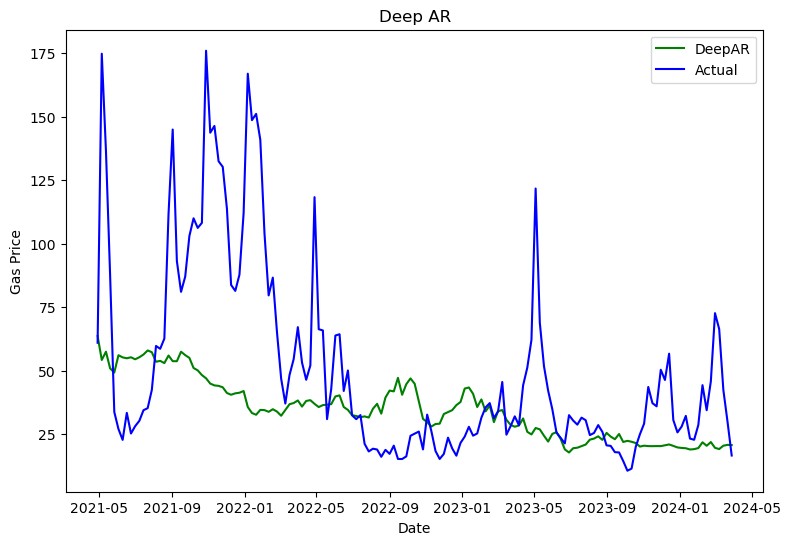

In [133]:
from matplotlib import pyplot
pyplot.figure(figsize = (9,6))
pyplot.plot(predictions.index, predictions["0.5"], color='green', label='DeepAR')
pyplot.plot(predictions.index, test_data[0]['target'][len(training_data[0]['target']):], color='blue', label='Actual')
pyplot.xlabel("Date")
pyplot.ylabel("Gas Price")
pyplot.title("Deep AR")
pyplot.legend()
pyplot.show()

In [60]:
# REMEMBER TO RUN THIS
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: deepar-gas-prices-2024-04-02-22-10-36-088
INFO:sagemaker:Deleting endpoint configuration with name: deepar-gas-prices-2024-04-02-22-10-36-088
INFO:sagemaker:Deleting endpoint with name: deepar-gas-prices-2024-04-02-22-10-36-088
